<a href="https://colab.research.google.com/github/AlexMourao19/Computer-Vision/blob/main/M%26M_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Body>
<h1><b>Computer Vision 2022/2023</b></h1>
<p><p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---
**Alexandre Mourão** & **Pedro Duarte**

In [ ]:
from google.colab import files
uploaded = files.upload()

# Intrinsic Calibration

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import glob

# Define the size of the chessboard pattern used for calibration
pattern_size = (4, 7)

# Create arrays to store object points (3D points) and image points (2D points)
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Define the real world coordinates of the chessboard pattern
objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

# Load calibration images
calibration_images = glob.glob('./IntrinsicCalibration/*.png')

# Loop through each calibration image
for calibration_image in calibration_images:
  # Load the image
  img = cv2.imread(calibration_image)

  # Convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Find the chessboard corners
  ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

  # If corners are found, add object points and image points
  if ret == True:
      objpoints.append(objp)
      imgpoints.append(corners)

      # Draw and display the corners
      cv2.drawChessboardCorners(img, pattern_size, corners, ret)
      #cv2_imshow(img)
      cv2.waitKey(500)

# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Print the intrinsic matrix and lens distortion coefficients
print("Intrinsic Matrix:")
print(mtx)
print("Distortion Coefficients:")
print(dist)

Intrinsic Matrix:
[[1.32389884e+03 0.00000000e+00 9.91163276e+02]
 [0.00000000e+00 1.32475673e+03 6.34400622e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
[[-0.35173525  0.10764796  0.00061637 -0.00041242 -0.01338397]]


---
# Extrinsic Calibration

In [ ]:
# Load the extrinsic image
image_dis = cv2.imread('./WhiteBackground/extrinsic.png')
img = cv2.undistort(image_dis, mtx, dist, None)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Define the size of the black square in the chessboard pattern (in millimeters)
square_size = 22

# Define the dimensions of the chessboard pattern
pattern_size = (4, 7)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

# Calculate the conversion ratio between pixel and millimeter
n = 1
if ret == True:
    # Calculate the distance between the corners of a black square
    for i in range(len(corners) - 1):
      if not(i == 3 or i == 7 or i == 11 or i == 15 or i == 19 or i == 23):
        square_distance_pixels = np.linalg.norm(corners[i] - corners[i + 1])
        pixel_to_mm = pixel_to_mm + (square_size / square_distance_pixels)
        n = n + 1

    pixel_to_mm = pixel_to_mm/n

    # Print the conversion ratio
    print("Conversion ratio (pixel to mm):", pixel_to_mm)

    # Calculate the extrinsic matrix
    ret, rvecs, tvecs = cv2.solvePnP(np.zeros((pattern_size[0]*pattern_size[1],3), np.float32), corners, mtx, dist)
    R, _ = cv2.Rodrigues(rvecs)
    extrinsic_matrix = np.hstack((R, tvecs))
    print("Extrinsic Matrix:")
    print(extrinsic_matrix)
else:
    print("Error: chessboard corners not found.")

Conversion ratio (pixel to mm): 0.1807386731044527
Extrinsic Matrix:
[[-6.16781257e-01  7.57829333e-01  2.12780597e-01  3.22531175e-02]
 [ 3.85407658e-01  5.26455733e-01 -7.57829333e-01 -1.45820569e-01]
 [-6.86324863e-01 -3.85407658e-01 -6.16781257e-01 -9.32392118e-19]]


---
# White Background

**Region of interest**

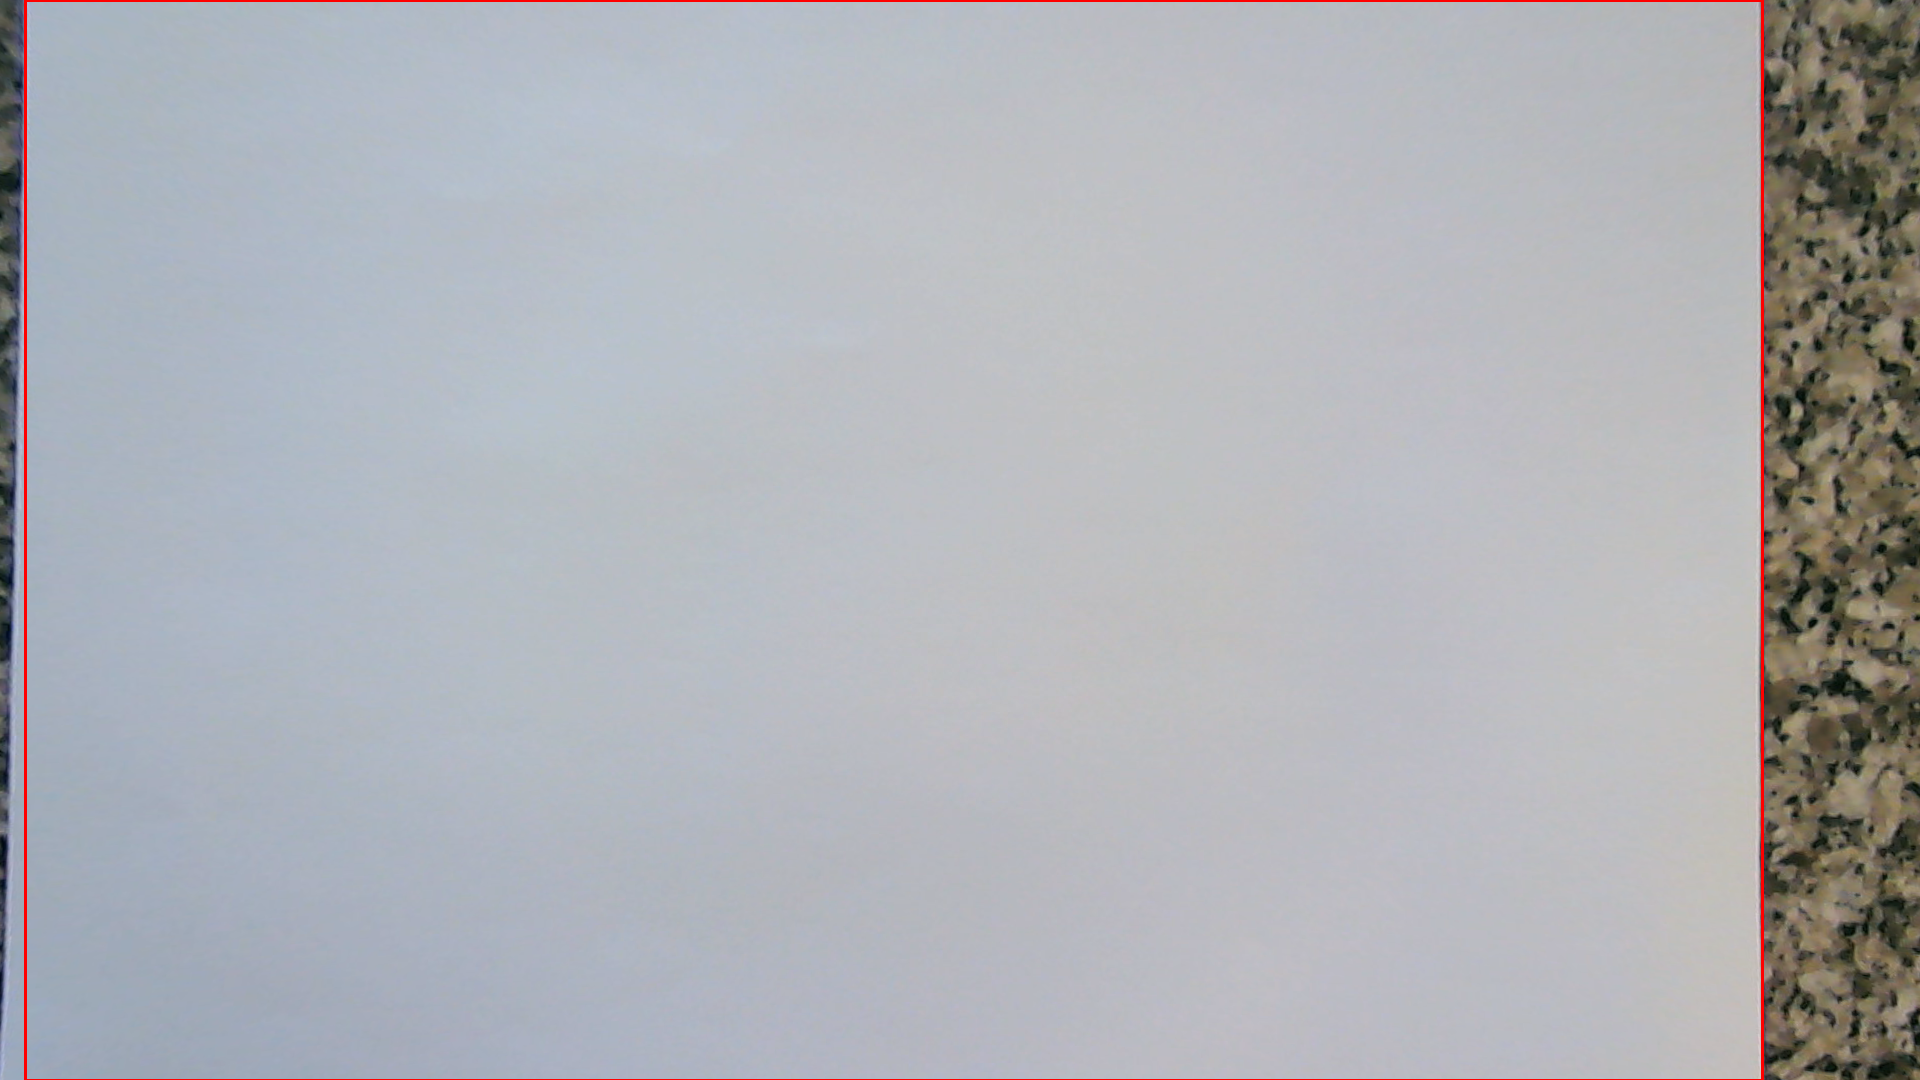

In [ ]:
# Read image and undistort it
img_dist = cv2.imread('./WhiteBackground/calib_img 0.png')
img = cv2.undistort(img_dist, mtx, dist, None)

# Convert to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Convert to binary
binary = cv2.threshold(img_gray, 177, 255, cv2.THRESH_BINARY)[1]

# Find contours
contours = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

# Find and draw ROI
for c in contours:
  if (cv2.contourArea(c) > 20000):
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)

# Show image with ROI
cv2_imshow(img)

**Number of M&M per color**

In [ ]:
kernel = np.ones((9, 9), 'uint8')
images = ['./WhiteBackground/calib_img 0.png', './WhiteBackground/calib_img 1.png',
          './WhiteBackground/calib_img 2.png', './WhiteBackground/calib_img 3.png']

for image in images:
  print("----------------------------")
  image_dis = cv2.imread(image)
  img = cv2.undistort(image_dis, mtx, dist, None)
  roi = img[y:y+h, x:x+w]
  hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

  # Red
  Red1 = cv2.inRange(hsv, (0, 100, 100), (10, 255, 255))
  Red2 = cv2.inRange(hsv, (170, 100, 100), (180,255,255))
  Red = Red1 + Red2
  dilated = cv2.dilate(Red, kernel, iterations=2)
  eroded = cv2.erode(dilated, kernel, iterations=1)
  RedCount, labels, statsRed, centroids = cv2.connectedComponentsWithStats(eroded, connectivity=8)
  RedCount = RedCount - 1
  print("Red: ", RedCount)
  # cv2_imshow(eroded)

  # Yellow
  Yellow = cv2.inRange(hsv, (20, 100, 100), (45, 255, 255))
  eroded = cv2.erode(Yellow, kernel, iterations=1)
  dilated = cv2.dilate(eroded, kernel, iterations=1)
  YellowCount, labels, statsYellow, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8)
  YellowCount = YellowCount - 1
  print("Yellow: ", YellowCount)
  # cv2_imshow(dilated)

  # Blue
  Blue = cv2.inRange(hsv, (90, 110, 50), (115, 255, 255))
  eroded = cv2.erode(Blue, kernel, iterations=1)
  dilated = cv2.dilate(eroded, kernel, iterations=2)
  BlueCount, labels, statsBlue, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8)
  BlueCount = BlueCount - 1
  print("Blue: ", BlueCount)
  # cv2_imshow(dilated)

  # Green
  Green = cv2.inRange(hsv, (35, 50, 50), (90, 255, 255))
  eroded = cv2.erode(Green, kernel, iterations=1)
  dilated = cv2.dilate(eroded, kernel, iterations=2)
  GreenCount, labels, statsGreen, centroids = cv2.connectedComponentsWithStats(dilated, connectivity=8)
  GreenCount = GreenCount - 1
  print("Green: ", GreenCount)
  # cv2_imshow(dilated)

----------------------------
Red:  0
Yellow:  0
Blue:  0
Green:  0
----------------------------
Red:  0
Yellow:  5
Blue:  5
Green:  0
----------------------------
Red:  5
Yellow:  5
Blue:  5
Green:  0
----------------------------
Red:  5
Yellow:  5
Blue:  5
Green:  3


**Average Area**

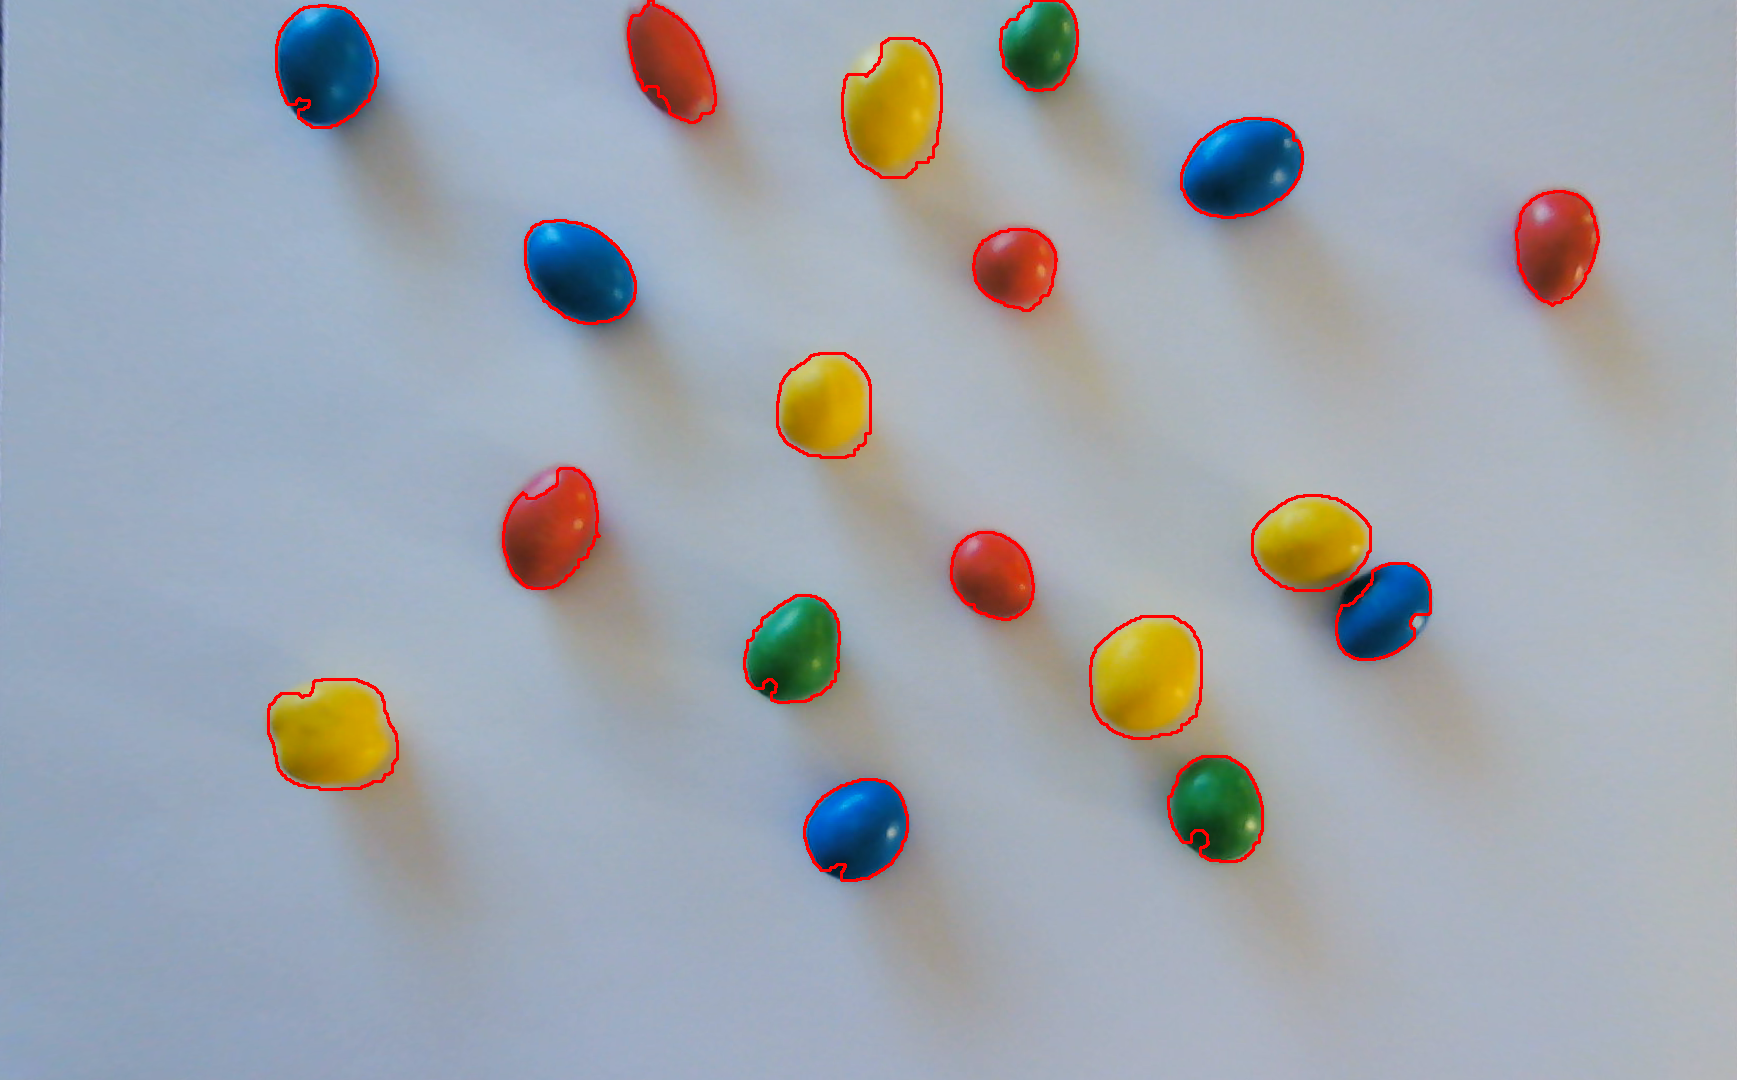

Average area of peanuts: 8034.972222222223 pixels or 1452.2302178755804 mm


In [ ]:
# Load the image
image_dis = cv2.imread('./WhiteBackground/calib_img 3.png')
image = cv2.undistort(image_dis, mtx, dist, None)
img = image[y:y+h, x:x+w]
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Blue
Blue = cv2.inRange(hsv, (90, 110, 50), (115, 255, 255))
eroded = cv2.erode(Blue, kernel, iterations=1)
Blue = cv2.dilate(eroded, kernel, iterations=1)

# Green
Green = cv2.inRange(hsv, (35, 50, 50), (90, 255, 255))
eroded = cv2.erode(Green, kernel, iterations=1)
Green = cv2.dilate(eroded, kernel, iterations=1)

# Red
Red1 = cv2.inRange(hsv, (0, 100, 100), (10, 255, 255))
Red2 = cv2.inRange(hsv, (170, 100, 100), (180,255,255))
Red = Red1 + Red2
dilated = cv2.dilate(Red, kernel, iterations=1)
Red = cv2.erode(dilated, kernel, iterations=1)

# Yellow
Yellow = cv2.inRange(hsv, (20, 100, 100), (45, 255, 255))
eroded = cv2.erode(Yellow, kernel, iterations=1)
Yellow = cv2.dilate(eroded, kernel, iterations=2)

result = Red + Yellow + Green + Blue

# Find the contours in the binary image
contours, _ = cv2.findContours(result, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Store the areas of the contours in a list
areas = []
for cnt in contours:
    if cv2.contourArea(cnt) > 1500:
      area = cv2.contourArea(cnt)
      areas.append(area)

# Compute the average area of the peanuts
avg_area = sum(areas) / len(areas)

# Draw the contours on the original image
for cnt in contours:
    if cv2.contourArea(cnt) > 1500:
      cv2.drawContours(img, [cnt], 0, (0, 0, 255), 2)

# Show the image with detected peanuts
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

avg_area_mm = avg_area*pixel_to_mm
# Print the average area of the peanuts
print(f"Average area of peanuts: {avg_area} pixels or {avg_area_mm} mm")

The method used to detect peanuts using *cv2.findContours* has some limitations that can affect its accuracy and reliability. One of them is lighting variations, changes in lighting conditions can affect the thresholding process used to extract the peanut objects, other is overlapping peanuts if the peanuts are too close to each other or overlap, it may be difficult to separate them accurately using this method.

**Average area of each colour and standart deviation**

In [ ]:
# Load the image
from prettytable import PrettyTable

images = ['./WhiteBackground/calib_img 2.png', './WhiteBackground/calib_img 3.png']
n = 1
areas = {}
for image in images:

  image_dis = cv2.imread(image)
  image = cv2.undistort(image_dis, mtx, dist, None)
  img = image[y:y+h, x:x+w]
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # Blue
  Blue = cv2.inRange(hsv, (90, 110, 50), (115, 255, 255))
  eroded = cv2.erode(Blue, kernel, iterations=1)
  Blue = cv2.dilate(eroded, kernel, iterations=1)
  BlueCount, labels, statsBlue, centroids = cv2.connectedComponentsWithStats(Blue, connectivity=8)
  areas[0] = np.mean(statsBlue[1:, cv2.CC_STAT_AREA]) * pixel_to_mm

  # Green
  Green = cv2.inRange(hsv, (35, 50, 50), (90, 255, 255))
  eroded = cv2.erode(Green, kernel, iterations=1)
  Green = cv2.dilate(eroded, kernel, iterations=1)
  GreenCount, labels, statsGreen, centroids = cv2.connectedComponentsWithStats(Green, connectivity=8)
  areas[1] = np.mean(statsGreen[1:, cv2.CC_STAT_AREA]) * pixel_to_mm

  # Red
  Red1 = cv2.inRange(hsv, (0, 100, 100), (10, 255, 255))
  Red2 = cv2.inRange(hsv, (170, 100, 100), (180,255,255))
  Red = Red1 + Red2
  dilated = cv2.dilate(Red, kernel, iterations=1)
  Red = cv2.erode(dilated, kernel, iterations=1)
  RedCount, labels, statsRed, centroids = cv2.connectedComponentsWithStats(Red, connectivity=8)
  areas[2] = np.mean(statsRed[1:, cv2.CC_STAT_AREA]) * pixel_to_mm

  # Yellow
  Yellow = cv2.inRange(hsv, (20, 100, 100), (45, 255, 255))
  eroded = cv2.erode(Yellow, kernel, iterations=1)
  Yellow = cv2.dilate(eroded, kernel, iterations=2)
  YellowCount, labels, statsYellow, centroids = cv2.connectedComponentsWithStats(Yellow, connectivity=8)
  areas[3] = np.mean(statsYellow[1:, cv2.CC_STAT_AREA]) * pixel_to_mm

  deviation = {}
  for i in areas:
    deviation[i] = abs(areas[i] - avg_area_mm)

  # Print the average area of the peanuts
  table = PrettyTable()
  table1 = PrettyTable()
  print("Image ", n)
  table.add_column("Color", ["Blue", "Green", "Red", "Yellow"])
  table.add_column("Average Area in mm", [ areas[0],
                                           areas[1],
                                           areas[2],
                                           areas[3]])

  table.add_column("Standart deviation", [ deviation[0],
                                           deviation[1],
                                           deviation[2],
                                           deviation[3]])
  n = n + 1
  print(table)

Image  1
+--------+--------------------+--------------------+
| Color  | Average Area in mm | Standart deviation |
+--------+--------------------+--------------------+
|  Blue  | 1490.9494621732515 | 38.71924429767114  |
| Green  |        nan         |        nan         |
|  Red   | 1224.7213966903923 | 227.50882118518803 |
| Yellow | 1885.8273151718597 | 433.59709729627934 |
+--------+--------------------+--------------------+
Image  2
+--------+--------------------+--------------------+
| Color  | Average Area in mm | Standart deviation |
+--------+--------------------+--------------------+
|  Blue  | 1513.9394213921375 | 61.70920351655718  |
| Green  | 1272.1592737578746 | 180.07094411770572 |
|  Red   | 982.4653038836208  | 469.7649139919596  |
| Yellow | 1857.0537184136306 | 404.8235005380502  |
+--------+--------------------+--------------------+


The limitations using *cv2.connectedComponentsWithStats* are similar to the limitations above when using *cv2.findContours*, but we can enumerate some more like thresholding, the method relies on setting appropriate thresholding parameters to extract the peanut objects from the background. If the thresholding is not set correctly, some peanuts may not be detected or may be detected as false positives.

**Recomendations**

There are many ways to improve the results for the M&M factory such as:

Ensure that the imaging setup is consistent across all production lines, by using standardized lighting and camera equipment. This will help to minimize variability in the images captured and improve the accuracy of the image processing.

Regularly calibrate the camera and lens system to ensure accurate measurements and minimize distortion, which can affect the precision of object detection and sizing.

Incorporate real-time monitoring and feedback mechanisms into the quality assurance process to enable quick adjustments and reduce the likelihood of defects going unnoticed for prolonged periods.


---
# Grey Background

**Number of M&M per color**

In [ ]:
images =['./GreyBackground/calib_img 0.png', './GreyBackground/calib_img 1.png',
         './GreyBackground/calib_img 2.png', './GreyBackground/calib_img 3.png',
         './GreyBackground/calib_img 4.png', './GreyBackground/calib_img 5.png']

# Define kernels
kernel_7 = np.ones((7, 7), 'uint8')
kernel_9 = np.ones((9, 9), 'uint8')

# Loop over all images to calculate the number of M&M per color
for image in images:
  print("----------------------------")

  # Read image and undistort it
  img_dist = cv2.imread(image)
  img = cv2.undistort(img_dist, mtx, dist, None)

  # Apply Gaussian blur
  blur = cv2.GaussianBlur(img, (5, 5), 0)

  # Convert to HSV
  hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

  # RED
  red = cv2.inRange(hsv, (0, 70, 100), (10, 255, 255)) + cv2.inRange(hsv, (170, 70, 100), (180, 255, 255))
  eroded = cv2.erode(red, kernel_9, iterations=2)
  dilated = cv2.dilate(eroded, kernel_7, iterations=2)
  redCount = cv2.connectedComponentsWithStats(dilated, connectivity=8)[0]
  redCount = redCount - 1
  print("Red: ", redCount)
  # cv2_imshow(dilated)

  # YELLOW
  yellow = cv2.inRange(hsv, (20, 70, 200), (40, 255, 255))
  eroded = cv2.erode(yellow, kernel_9, iterations=3)
  dilated = cv2.dilate(eroded, kernel_7, iterations=3)
  yellowCount = cv2.connectedComponentsWithStats(dilated, connectivity=8)[0]
  yellowCount = yellowCount - 1
  print("Yellow: ", yellowCount)
  # cv2_imshow(dilated)

  # BLUE
  blue = cv2.inRange(hsv, (100, 70, 100), (120, 255, 255))
  eroded = cv2.erode(blue, kernel_9, iterations=4)
  dilated = cv2.dilate(eroded, kernel_7, iterations=4)
  blueCount = cv2.connectedComponentsWithStats(dilated, connectivity=8)[0]
  blueCount = blueCount - 1
  print("Blue: ", blueCount)
  # cv2_imshow(dilated)

  # GREEN
  green = cv2.inRange(hsv, (50, 70, 100), (85, 255, 255))
  eroded = cv2.erode(green, kernel_9, iterations=1)
  dilated = cv2.dilate(eroded, kernel_7, iterations=1)
  greenCount = cv2.connectedComponentsWithStats(dilated, connectivity=8)[0]
  greenCount = greenCount - 1
  print("Green: ", greenCount)
  # cv2_imshow(dilated)

  # BROWN
  brown = cv2.inRange(hsv, (0, 50, 50), (25, 255, 150)) + cv2.inRange(hsv, (150, 50, 50), (180, 255, 127))
  eroded = cv2.erode(brown, kernel_9, iterations=1)
  dilated = cv2.dilate(eroded, kernel_9, iterations=3)
  eroded = cv2.erode(dilated, kernel_9, iterations=4)
  dilated = cv2.dilate(eroded, kernel_9, iterations=2)
  brownCount = cv2.connectedComponentsWithStats(dilated, connectivity=8)[0]
  brownCount = brownCount - 1
  print("Brown: ", brownCount)
  # cv2_imshow(dilated)

----------------------------
Red:  0
Yellow:  0
Blue:  0
Green:  0
Brown:  0
----------------------------
Red:  0
Yellow:  5
Blue:  7
Green:  0
Brown:  0
----------------------------
Red:  0
Yellow:  5
Blue:  7
Green:  3
Brown:  0
----------------------------
Red:  5
Yellow:  5
Blue:  7
Green:  3
Brown:  0
----------------------------
Red:  5
Yellow:  5
Blue:  7
Green:  3
Brown:  5
----------------------------
Red:  4
Yellow:  5
Blue:  6
Green:  3
Brown:  5


**Average area**

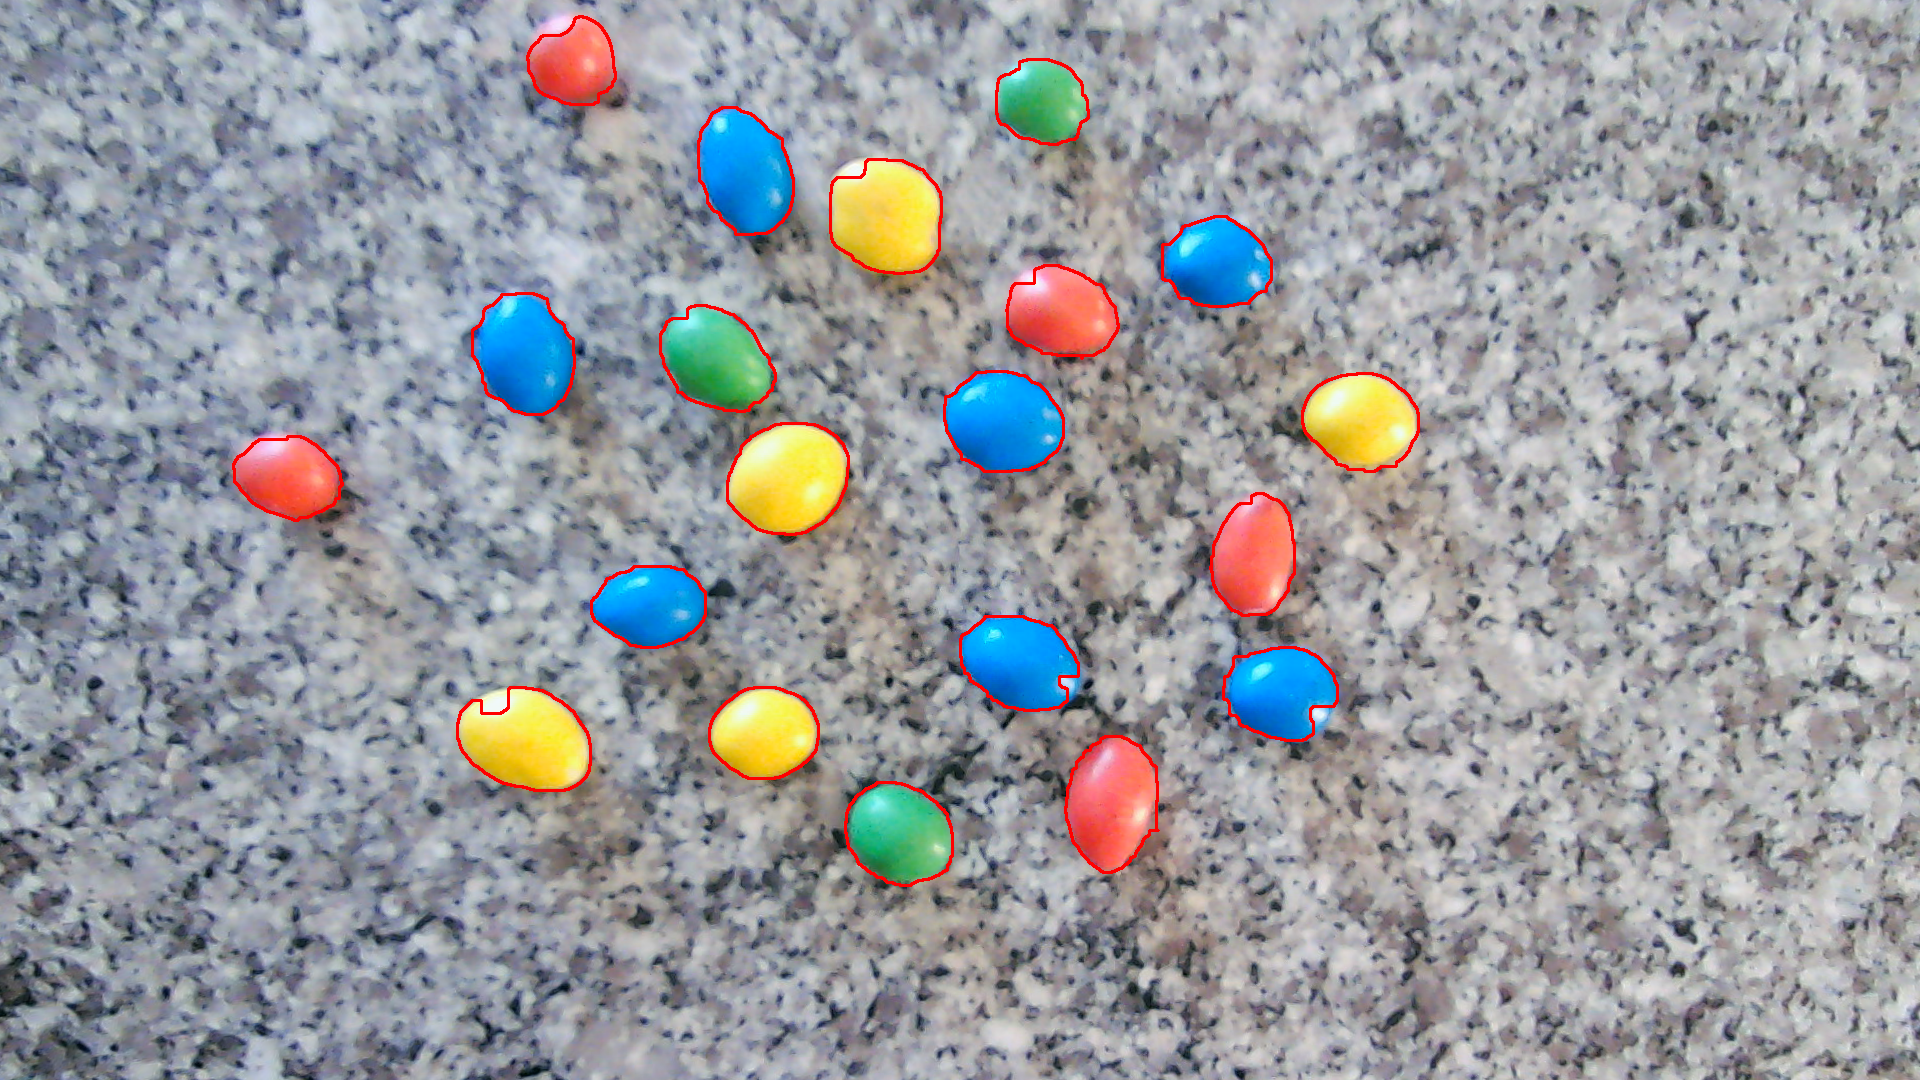

Average area of peanuts: 8351.575 pixels or 1509.4525838323198 mm

calib_img 3.png
Color      Average area (mm)    Standard deviation
-------  -------------------  --------------------
Red                  1343.36              166.094
Yellow               1718.28              208.83
Blue                 1521.57               12.1218
Green                1409.94               99.5102

calib_img 2.png
Color      Average area (mm)    Standard deviation
-------  -------------------  --------------------
Red                  1556.43               29.3098
Yellow               1544.28               17.1616
Blue                 1413.05              114.076
Green                   0                   0


In [ ]:
from numpy.lib.function_base import average
from tabulate import tabulate

images = ['./GreyBackground/calib_img 3.png', './GreyBackground/calib_img 2.png']
j = 1

for image in images:
  # Read image and undistort it
  img_dist = cv2.imread(image)
  img = cv2.undistort(img_dist, mtx, dist, None)

  # Apply Gaussian blur
  blur = cv2.GaussianBlur(img, (9, 9), 0)

  # Convert to HSV
  hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

  # RED
  red = cv2.inRange(hsv, (0, 70, 150), (10, 255, 255)) + cv2.inRange(hsv, (160, 70, 100), (180, 255, 255))
  dilated = cv2.dilate(red, kernel_9, iterations=3)
  eroded = cv2.erode(dilated, kernel_9, iterations=3)
  red = eroded
  # cv2_imshow(red)

  # YELLOW
  yellow = cv2.inRange(hsv, (20, 70, 200), (40, 255, 255))
  dilated = cv2.dilate(yellow, kernel_9, iterations=3)
  eroded = cv2.erode(dilated, kernel_7, iterations=3)
  yellow = eroded
  # cv2_imshow(yellow)

  # BLUE
  blue = cv2.inRange(hsv, (90, 70, 100), (120, 255, 255))
  eroded = cv2.erode(blue, kernel_9, iterations=2)
  dilated = cv2.dilate(eroded, kernel_7, iterations=2)
  blue = dilated
  # cv2_imshow(blue)

  # GREEN
  green = cv2.inRange(hsv, (50, 70, 100), (89, 255, 255))
  dilated = cv2.dilate(green, kernel_9, iterations=2)
  eroded = cv2.erode(dilated, kernel_7, iterations=2)
  green = eroded
  # cv2_imshow(green)

  # Create binary image
  result = cv2.bitwise_or(red, yellow)
  result = cv2.bitwise_or(result, blue)
  result = cv2.bitwise_or(result, green)

  # Find contours
  contours = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

  # Calculate average area of peanuts in pixels
  areas = []
  for cnt in contours:
      if cv2.contourArea(cnt) > 1500:
        area = cv2.contourArea(cnt)
        areas.append(area)
  avg_area = sum(areas) / len(areas)

  # Convert to millimeters
  area_mm = avg_area * pixel_to_mm

  if j == 1:
    # Draw contours on the original image
    for cnt in contours:
        if cv2.contourArea(cnt) > 1500:
          cv2.drawContours(img, [cnt], 0, (0, 0, 255), 2)

    # Show image with detected peanuts
    cv2_imshow(img)

    # Print average area of peanuts
    print(f"Average area of peanuts: {avg_area} pixels or {area_mm} mm")

  colors = [red, yellow, blue, green]
  colorArea = [0] * len(colors)
  deviation = [0] * len(colors)
  i = 0

  for color in colors:
    # Find contours for all colors
    contours = cv2.findContours(color, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # Calculate average area of peanuts per color in pixels
    areas = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 1500:
          area = cv2.contourArea(cnt)
          areas.append(area)
    if len(areas) == 0:
      continue
    avg_area = sum(areas) / len(areas)

    # Convert to millimeters
    colorArea[i] = avg_area * pixel_to_mm

    # Calculate stardard deviation
    deviation[i] = abs(colorArea[i] - area_mm)

    i += 1

  # Draw and print table
  table = [['Color', 'Average area (mm)', 'Standard deviation'],
          ['Red',    colorArea[0],        deviation[0]        ],
          ['Yellow', colorArea[1],        deviation[1]        ],
          ['Blue',   colorArea[2],        deviation[2]        ],
          ['Green',  colorArea[3],        deviation[3]        ]]

  if j == 1:
    print("\ncalib_img 3.png")
  if j == 2:
    print("\ncalib_img 2.png")
  print(tabulate(table, headers='firstrow'))

  j += 1

The method used to detect peanuts using cv2.findContours has some limitations that can affect its accuracy and reliability. One of them is lighting variations, changes in lighting conditions can affect the thresholding process used to extract the peanut objects, other is overlapping peanuts if the peanuts are too close to each other or overlap, it may be difficult to separate them accurately using this method.